In [56]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

In [57]:
# cleaned dataset
df = pd.read_csv("/Users/sa2/Desktop/TKH/The-CyberChase/merged_df_clean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543135 entries, 0 to 1543134
Data columns (total 47 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Src Port                    1543135 non-null  int64  
 1   Flow Duration               1543135 non-null  int64  
 2   Total Fwd Packet            1543135 non-null  int64  
 3   Total Bwd packets           1543135 non-null  int64  
 4   Total Length of Fwd Packet  1543135 non-null  float64
 5   Fwd Packet Length Max       1543135 non-null  float64
 6   Fwd Packet Length Min       1543135 non-null  float64
 7   Bwd Packet Length Max       1543135 non-null  float64
 8   Bwd Packet Length Min       1543135 non-null  float64
 9   Bwd Packet Length Mean      1543135 non-null  float64
 10  Bwd Packet Length Std       1543135 non-null  float64
 11  Flow Bytes/s                1543135 non-null  float64
 12  Flow Packets/s              1543135 non-null  float64
 1

In [58]:

# separate features and target
X = df.drop(columns=['Location_China','Location_France','Location_Germany','Location_Hong Kong','Location_Iran','Location_Italy','Location_Japan','Location_Singapore','Location_United Kingdom','Location_United States'])
y = df[['Location_China','Location_France','Location_Germany','Location_Hong Kong','Location_Iran','Location_Italy','Location_Japan','Location_Singapore','Location_United Kingdom','Location_United States']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# undoing one hot encoding (one country per row)
y_train_labels = y_train.idxmax(axis=1)
y_test_labels = y_test.idxmax(axis=1)

In [60]:
# Random Forest (baseline)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train_labels)
rf_preds = rf.predict(X_test)


In [61]:
print(accuracy_score(y_test_labels, rf_preds))
print(confusion_matrix(y_test_labels, rf_preds))
print(classification_report(y_test_labels, rf_preds))

0.7802395772242869
[[ 29297     47     95    326     81     40    392    104    117   3897]
 [    80   5107     22    403    136     24    203     10    389   1273]
 [   159     39  11016   2120   1544     40    311     50     49   2124]
 [   530    447   1465  24466   1305    125   1850     88    159   7760]
 [    15     13    518     95 101550    663     23      1    265   2953]
 [    81     10     65     37   1271   6208     92      7     14   1747]
 [   346    149    247   2467    392     56   8221    103    138   3309]
 [   202      8     78    268     22      6    237   5705      8    456]
 [   136    416    142    211   1057      9    112     37   3263   1334]
 [  1972    497   1165   9818   3938    499   1756    184    375  45970]]
                         precision    recall  f1-score   support

         Location_China       0.89      0.85      0.87     34396
        Location_France       0.76      0.67      0.71      7647
       Location_Germany       0.74      0.63      0.68

The baseline Random Forest model with default parameters established performance benchmark
&emsp;

Best Performing:
- Location_Iran: 96% recall, 91% precision (F1: 0.93)
- Location_China: 85% recall, 89% precision (F1: 0.87)
- Location_Singapore: 82% recall, 91% precision (F1: 0.86)
&emsp;

Poorest Performing:
- Location_United Kingdom: 49% recall, 68% precision (F1: 0.57)
- Location_Japan: 53% recall, 62% precision (F1: 0.57)
- Location_Hong Kong: 64% recall, 61% precision (F1: 0.62)
&emsp;

class imbalance issues. Iran dominates with 106,096 samples, leading to the best performance, while smaller classes like Singapore (6,990 samples) and UK (6,717 samples) struggle with recall

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
#for faster processsing of the models
X_sample, y_sample = resample(X_train, y_train_labels, 
                             n_samples=300000, 
                             random_state=42, 
                             stratify=y_train_labels)

In [63]:
#paramter search for random forest 

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20, 40],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_sample, y_sample)

print(random_search.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 0.5, 'max_depth': 30, 'class_weight': None}


In [64]:
#2nd random forest with hyperparmater tuning
best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train_labels)

best_preds = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test_labels, best_preds))
print(confusion_matrix(y_test_labels, best_preds))
print(classification_report(y_test_labels, best_preds))


Accuracy: 0.8244742034883532
[[ 29432     11      8    231     74     18    116     99     37   4370]
 [     8   5659      2    395    127     15     46      0    193   1202]
 [    41     17  11724   2128   1648      3    146     24      2   1719]
 [   497    447   1208  28854   1330    123   1454    141     90   4051]
 [     3      0    168      3 102552    258      0      0     38   3074]
 [    14      0     36      4   1226   6210     36      0      0   2006]
 [   166     64     96   1382    390     21  10515     87     44   2663]
 [   202      0     77    250     21      0     88   5936      0    416]
 [    29    498    147    167   1143      0     13     26   3238   1456]
 [   631    313    898   9779   3099    109    843    130     37  50335]]
                         precision    recall  f1-score   support

         Location_China       0.95      0.86      0.90     34396
        Location_France       0.81      0.74      0.77      7647
       Location_Germany       0.82      0.67

The First hyperparameter optimization Random Forest model
&emsp;

Optimal Parameters Found:
- n_estimators: 300
- max_depth: 30
- min_samples_split: 10
- min_samples_leaf: 20
- max_features: 0.5
- class_weight: None
&emsp;

Improvements:
- Location_France: 67% → 74% recall
- Location_Hong Kong: 64% → 76% recall
- Location_United_States: 69% → 76% recall
&emsp;

Maintained Performance:
- Location_Iran: Still leading with 97% recall, 92% precision
- Location_China: Improved to 86% recall, 95% precision
&emsp;

The hyperparameter optimization addressed some class imbalance issues. The increased tree depth (30) and higher number of estimators (300) allowed the model to capture more complex patterns

In [65]:
#looking at values close to the best hyperparamters of the last tuning
param_distributions = {
    'n_estimators': [250, 300, 350],
    'max_depth': [30, 35, 40],
    'min_samples_leaf': [15, 20, 25],
    'criterion': ['gini', 'entropy']
}

random_searchh = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, min_samples_split=10, max_features=0.5, class_weight=None),
    param_distributions,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=2,
    random_state=43
)

random_searchh.fit(X_sample, y_sample)
print(random_searchh.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 250, 'min_samples_leaf': 15, 'max_depth': 35, 'criterion': 'gini'}


In [66]:
#3rd random forest trying to find better hyperparams based on the last ones 
best_rff = RandomForestClassifier(**random_searchh.best_params_, random_state=42)
best_rff.fit(X_train, y_train_labels)

best_predss = best_rff.predict(X_test)
print("Accuracy:", accuracy_score(y_test_labels, best_predss))
print(confusion_matrix(y_test_labels, best_predss))
print(classification_report(y_test_labels, best_predss))


Accuracy: 0.7902840645828135
[[ 28652      1     12    492     74     19    275     67     46   4758]
 [    14   4907      4    431    133      8    246      4    358   1542]
 [    85     19   9814   2964   1806      2    296     25      4   2437]
 [   867    435    738  27773   1361    120   1686     47    115   5053]
 [     2      0     46      0 103167     58      0      0      2   2821]
 [    22      0     58     36   1412   5670    112      2      0   2220]
 [   208    108    165   3209    390     25   7281     38    101   3903]
 [   436      1     70    264     21      9    399   5169      8    613]
 [    46    294     60    315   1177      0     47     30   3017   1731]
 [  1029    252    580  11308   3472     64    930     49     37  48453]]
                         precision    recall  f1-score   support

         Location_China       0.91      0.83      0.87     34396
        Location_France       0.82      0.64      0.72      7647
       Location_Germany       0.85      0.56

In [72]:
report_dict = classification_report(y_test_labels, best_predss, output_dict=True)

report_df = pd.DataFrame(report_dict).T.drop(['accuracy', 'macro avg', 'weighted avg'])

report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'Country'}, inplace=True)

report_df['Country'] = report_df['Country'].str.replace('Location_', '')

report_df_sorted = report_df.sort_values(by='support', ascending=False)

print("Classification Report by Country:")
print(report_df_sorted)



Classification Report by Country:
          Country  precision    recall  f1-score   support
4            Iran   0.912877  0.972393  0.941696  106096.0
9   United States   0.658947  0.732206  0.693647   66174.0
3       Hong Kong   0.593542  0.727137  0.653582   38195.0
0           China   0.913619  0.833004  0.871451   34396.0
2         Germany   0.849918  0.562342  0.676851   17452.0
6           Japan   0.645937  0.471934  0.545393   15428.0
5           Italy   0.948954  0.594838  0.731283    9532.0
1          France   0.815523  0.641690  0.718238    7647.0
7       Singapore   0.951758  0.739485  0.832300    6990.0
8  United Kingdom   0.818059  0.449159  0.579914    6717.0


The Second hyperparameter optimization Random Forest model
&emsp;

Refined Parameters Found:
- n_estimators: 250 (reduced from 300)
- max_depth: 35 (increased from 30)
- min_samples_leaf: 15 (reduced from 20)
- criterion: 'gini'

Notable Performance Regression:
- Location_Germany: 67% → 56% recall
- Location_Japan: 68% → 47% recall
- Location_United Kingdom: 48% → 45% recall
- Location_Hong Kong: 76% → 73% recall
&emsp;

The refined search decreased performance despite targeting parameters closer to the optimal range.

Model Performance Summary:
- Baseline Model (78.02%) - Good starting point with default parameters
- First Optimization (82.45%) - Best performer with significant improvements
- Refined Search (79.03%) - Unexpected regression despite targeted optimization
&emsp;

Findings:
&emsp;

- Class imbalance affects performance
- Geographic classification challenges 
- more refined tuning can lead to overfitting, the first broad hyperparameter search often finds the best generalizable solution

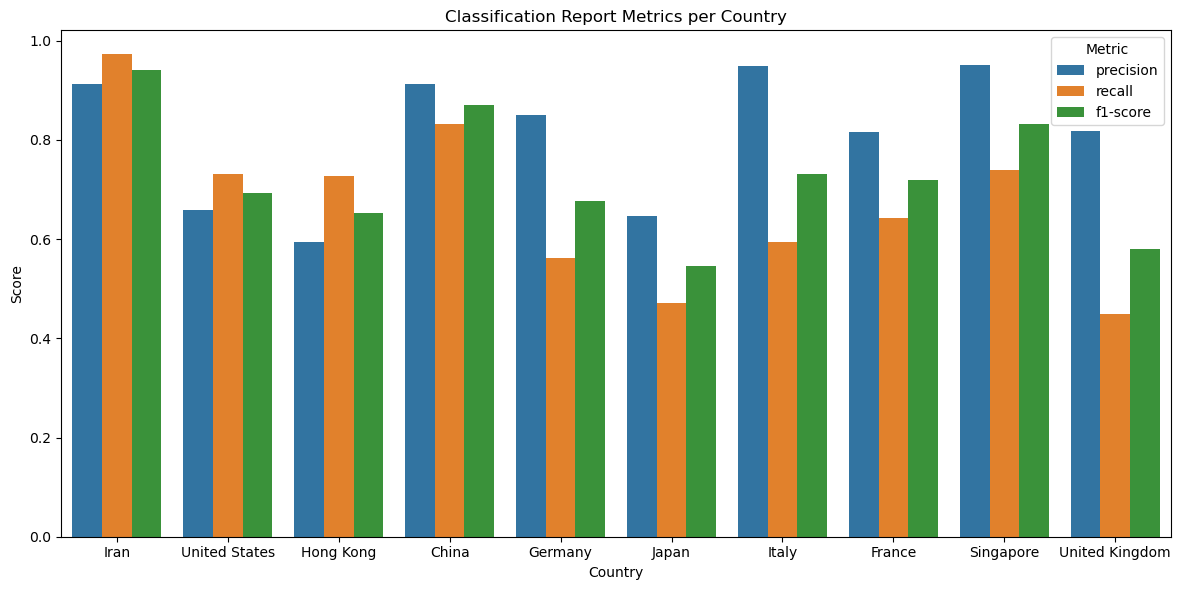

In [77]:
melted_df = report_df_sorted.melt(id_vars='Country', value_vars=['precision', 'recall', 'f1-score'], var_name='Metric', value_name= 'Score')

plt.figure(figsize=(12, 6))
sns.barplot (data=melted_df, x='Country', y='Score', hue="Metric")
plt.title("Classification Report Metrics by Country")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()